# pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,IsolationForest
from sklearn.preprocessing import RobustScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/properati_final.csv')

<IPython.core.display.Javascript object>

In [4]:
from datacleaner import autoclean

In [5]:
properati = autoclean(properati)

# Regresor

In [6]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['state_name'],properati['place_name'])
y = properati['price_aprox_usd']
print len(X)

136356


In [8]:
from xgboost import XGBRegressor

In [25]:
%%notify

xgb= XGBRegressor(nthread=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

learning_rate=np.arange(0.1,0.8,0.2)

param_grid = {"learning_rate": learning_rate,'min_child_weight':[1,3,5,6],'gamma':[i/10.0 for i in range(3,6)],'subsample':[i/10.0 for i in range(6,11)]}

search = RandomizedSearchCV(xgb, param_distributions=param_grid ,cv=5,n_iter=20) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 210.12 segundos para 20 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.817 (std: 0.004)
Promedio validation score: 0.719 (std: 0.028)
Promedio fit time: 1.358s
Hiper-parametros: {'subsample': 1.0, 'learning_rate': 0.50000000000000011, 'gamma': 0.5, 'min_child_weight': 5}

Puesto: 2
Promedio training score: 0.820 (std: 0.003)
Promedio validation score: 0.718 (std: 0.028)
Promedio fit time: 1.390s
Hiper-parametros: {'subsample': 1.0, 'learning_rate': 0.50000000000000011, 'gamma': 0.3, 'min_child_weight': 3}

Puesto: 2
Promedio training score: 0.820 (std: 0.003)
Promedio validation score: 0.718 (std: 0.028)
Promedio fit time: 1.214s
Hiper-parametros: {'subsample': 1.0, 'learning_rate': 0.50000000000000011, 'gamma': 0.5, 'min_child_weight': 3}

Puesto: 4
Promedio training score: 0.792 (std: 0.005)
Promedio validation score: 0.707 (std: 0.033)
Promedio fit time: 1.389s
Hiper-parametros: {'subsample': 1.0, 'learning_rate': 0.30000000000000004, 'gamma':

<IPython.core.display.Javascript object>

# Clasificador

In [1]:
from xgboost import XGBClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
%%notify

xgb= XGBClassifier(nthread=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

learning_rate=np.arange(0.1,0.8,0.2)

param_grid = {"learning_rate": learning_rate,'min_child_weight':[1,3,5,6],'gamma':[i/10.0 for i in range(3,6)],'subsample':[i/10.0 for i in range(6,11)]}

search = RandomizedSearchCV(xgb, param_distributions=param_grid ,cv=5,n_iter=10) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

###  Analsis de errores

In [26]:
search.score(X_test,y_test)

0.45129089948307743

In [27]:
mejor = search.best_estimator_
errores = mejor.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:44537029.5
Error minimo:6.15625
80305     -24541.015625
113921      6582.796875
88467     -22940.601562
49523      31627.250000
81025     107615.093750
31475      15831.140625
38243      -6054.468750
53889      48163.812500
9150      -11039.140625
27808     103775.765625
98949      13662.015625
61858      30526.906250
134217     23944.703125
18821      16666.937500
128144    -14775.578125
51897      29337.375000
54498     -32629.218750
47224     -47440.859375
25713      32827.015625
59534      56042.187500
46145    -250599.109375
128211     59706.906250
105132    237429.187500
53844     173017.562500
14069     -32695.460938
22270      10960.234375
28302      21178.875000
32600     -52914.703125
17991    -247438.437500
32542       1943.921875
              ...      
53701      38163.812500
130359    -41572.546875
47767     -12187.953125
133176     24781.500000
134427     32604.546875
126938    145358.468750
36088     -65808.625000
36282     157562.625000
45447       5387.81

In [28]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 26750 de 27272 que tienen mas de 1000 USD de error (98%)


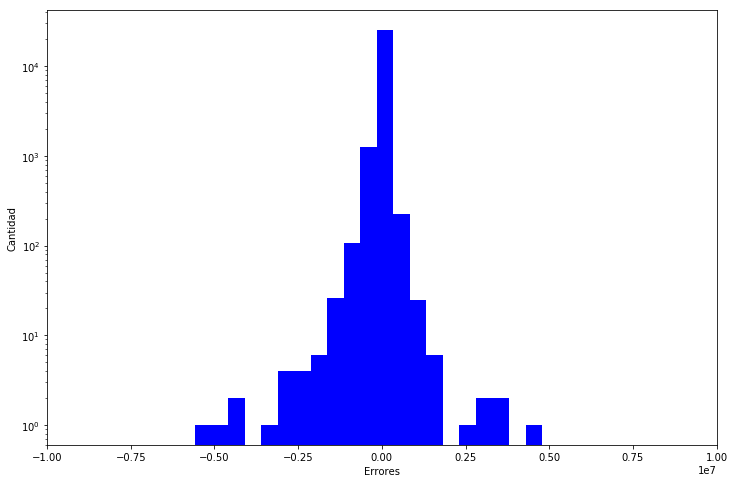

In [32]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()